In [1]:
!pip install --upgrade pip
!pip install -q efficientnet

In [2]:
import numpy as np 
import pandas as pd

import time
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet101, ResNet152, ResNet50, ResNet50V2, ResNet101V2, ResNet152V2, VGG16, VGG19
from efficientnet.tfkeras import EfficientNetB7, EfficientNetL2

from tensorflow.keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using TensorFlow backend.


Number of images in train set :  2100
Number of images in test set :  2290
Number of images in val set :  705


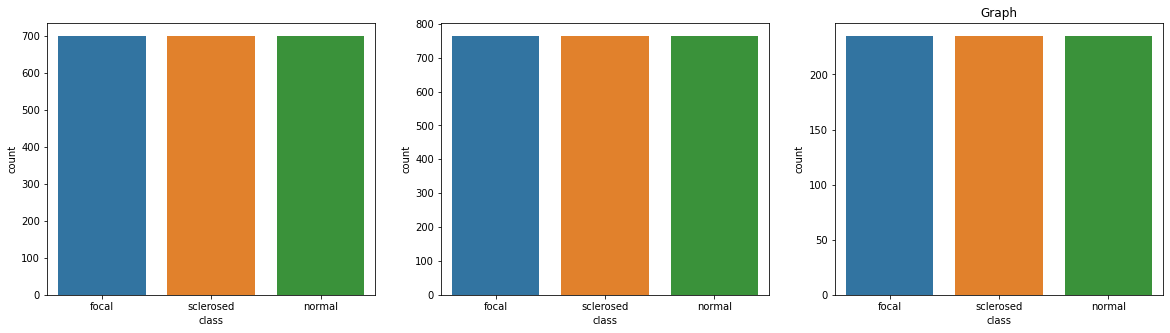

In [3]:
root_path = '/mnt/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/glomeruli/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/mnt/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/glomeruli/train/' #one more seg_train folder within
test_folders = '/mnt/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/glomeruli/test/'
val_folders = '/mnt/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/glomeruli/val/'
new_data_folders = '/mnt/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/main-data-glomeruli/raw_tiles/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
quantity_ne = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

for folder in os.listdir(new_data_folders):
    quantity_ne[folder] = len(os.listdir(new_data_folders+folder))
    
quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])
quantity_new_data = pd.DataFrame(list(quantity_ne.items()), index=range(0,len(quantity_ne)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
plt.title('Graph')
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))

plt.show()

In [4]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [5]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(train_folders,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                              shuffle=True, 
                                                              batch_size=1, 
                                                              class_mode='categorical', 
                                                              target_size=(150, 150))

Found 2100 images belonging to 3 classes.
Found 705 images belonging to 3 classes.


In [6]:
test_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
test_generator = train_datagen.flow_from_directory(test_folders,
                                                   batch_size=32,
                                                   shuffle=True,
                                                   class_mode='categorical',
                                                   target_size=(150, 150))

new_data_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
new_data_generator = validation_datagen.flow_from_directory(new_data_folders, 
                                                            shuffle=True, 
                                                            batch_size=1, 
                                                            class_mode='categorical', 
                                                            target_size=(150, 150))

Found 2290 images belonging to 3 classes.
Found 1585 images belonging to 8 classes.


In [7]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'focal': 0, 'normal': 1, 'sclerosed': 2}
{0: 'focal', 1: 'normal', 2: 'sclerosed'}


In [8]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            
            display = plt.imread(os.path.join(train_folders,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                if(predict_using_model == resnet50_pred):
                    predicted_classname = inv_map_classes[np.argmax(resnet50_best_model.predict(np.array([display])))]
                    title = title+'\nPredict :'+predicted_classname
                elif(predict_using_model == resnet50v2_pred):
                    predicted_classname = inv_map_classes[np.argmax(resnet50v2_best_model.predict(np.array([display])))]
                    title = title+'\nPredict :'+predicted_classname
                elif(predict_using_model == vgg16_pred):
                    predicted_classname = inv_map_classes[np.argmax(vgg16_best_model.predict(np.array([display])))]
                    title = title+'\nPredict :'+predicted_classname
                elif(predict_using_model == vgg19_pred):
                    predicted_classname = inv_map_classes[np.argmax(vgg19_best_model.predict(np.array([display])))]
                    title = title+'\nPredict :'+predicted_classname
                elif(predict_using_model == effb7_pred):
                    predicted_classname = inv_map_classes[np.argmax(effb7_best_model.predict(np.array([display])))]
                    title = title+'\nPredict :'+predicted_classname
                elif(predict_using_model == effl2_pred):
                    predicted_classname = inv_map_classes[np.argmax(effl2_best_model.predict(np.array([display])))]
                    title = title+'\nPredict :'+predicted_classname
                elif(predict_using_model == combine_resnet_pred):
                    predicted_classname = inv_map_classes[np.argmax(combine_resnet_best_model.predict(np.array([display])))]
                    title = title+'\nPredict :'+predicted_classname
                elif(predict_using_model == combine_vgg_pred):
                    predicted_classname = inv_map_classes[np.argmax(combine_vgg_best_model.predict(np.array([display])))]
                    title = title+'\nPredict :'+predicted_classname
                elif(predict_using_model == combine_effnet_pred):
                    predicted_classname = inv_map_classes[np.argmax(combine_effnet_best_model.predict(np.array([display])))]
                    title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

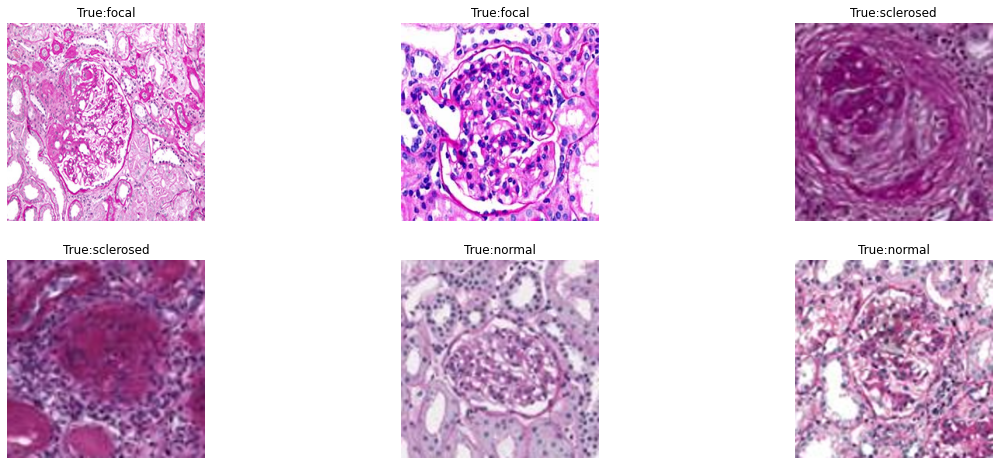

In [9]:
show_few_images(2,None)

In [10]:
tf.keras.backend.clear_session()

# epoch config
vgg_epoch = 60
resnet_epoch = 60
effnet_epoch = 60

## VGG16

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


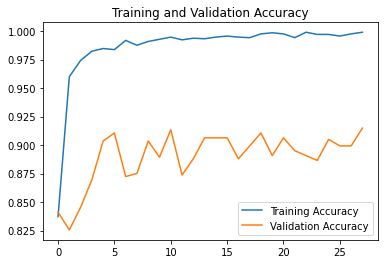

<Figure size 432x288 with 0 Axes>

/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


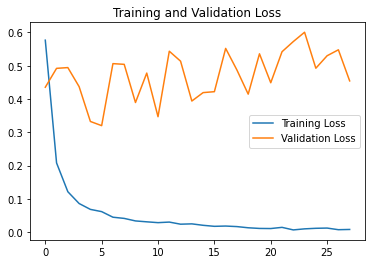

<Figure size 432x288 with 0 Axes>

In [11]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(150,150,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(3, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
number_of_epochs = vgg_epoch
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

vgg16_final_model.summary()
since = time.time()
vgg16_history = vgg16_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(vgg16_history, 'vgg16_model')

In [12]:
vgg16_final_model.evaluate(test_generator)
vgg16_best_model = vgg16_final_model

  ...
    to  
  ['...']
72/72 [==============================] - 67s 931ms/step - loss: 3.5140 - acc: 0.4773


## VGG19

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


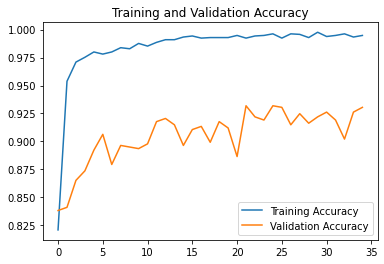

<Figure size 432x288 with 0 Axes>

/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


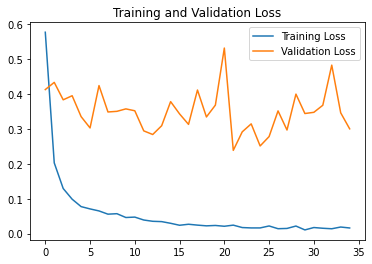

<Figure size 432x288 with 0 Axes>

In [13]:
vgg19_model = VGG19(pooling='avg', weights='imagenet', include_top=False, input_shape=(150,150,3))
for layers in vgg19_model.layers:
            layers.trainable=False
last_output = vgg19_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(3, activation = 'softmax')(vgg_x)
vgg19_final_model = Model(vgg19_model.input, vgg_x)
vgg19_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG19
number_of_epochs = vgg_epoch
vgg19_filepath = 'vgg_19_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg19_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

vgg19_final_model.summary()
since = time.time()
vgg19_history = vgg19_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(vgg19_history, 'vgg19_model')

In [14]:
vgg19_final_model.evaluate(test_generator)
vgg19_best_model = vgg19_final_model

  ...
    to  
  ['...']
72/72 [==============================] - 16s 216ms/step - loss: 3.3402 - acc: 0.4838


## ResNet101

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 66 steps, validate for 705 steps
Epoch 1/60
65/66 [============================>.] - ETA: 0s - loss: 0.3816 - acc: 0.9371
Epoch 00001: val_acc improved from -inf to 0.33333, saving model to resnet101-saved-model-01-val_acc-0.33.hdf5
66/66 [==============================] - 39s 596ms/step - loss: 0.3759 - acc: 0.9381 - val_loss: 15.3463 - val_acc: 0.3333
Epoch 2/60
65/66 [============================>.] - ETA: 0s - loss: 0.0194 - acc: 0.9952
Epoch 00002: val_acc did not improve from 0.33333
66/66 [==============================] - 30s 449ms/step - loss: 0.0193 - acc: 0.9952 - val_loss: 1.2233 - val_acc: 0.3333
Epoch 3/60
65/66 [============================>.] - ETA: 0s - loss: 0.0022 - acc: 0.9995
Epoch 00003: val_acc did not improve from 0.33333
66/66 [==============================] - 30s 447ms/step - loss: 0.0024 - acc: 0.9995 - val_loss: 2.0415 - val_acc: 0.3333
Epoch 4/60
65/66 [============================>.] - ETA: 0s - 

/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


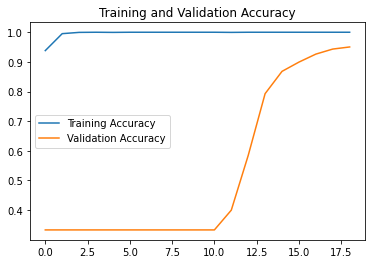

<Figure size 432x288 with 0 Axes>

/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


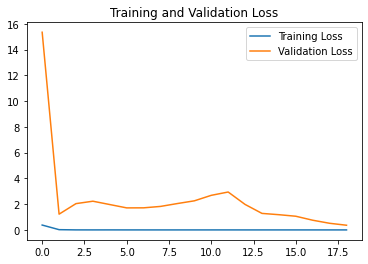

<Figure size 432x288 with 0 Axes>

In [15]:
ResNet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(150,150,3), classes=3)

for layers in ResNet101_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet101_x = Flatten()(ResNet101_model.output)
resnet101_x = Dense(256,activation='relu')(resnet101_x)
resnet101_x = Dense(3,activation='softmax')(resnet101_x)
resnet101_x_final_model = Model(inputs=ResNet101_model.input, outputs=resnet101_x)
resnet101_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = resnet_epoch
resnet_filepath = 'resnet101'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]

resnet101_x_final_model.summary()
since = time.time()
resnet101_history = resnet101_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet101_history, 'resnet101_model')

In [16]:
resnet101_x_final_model.evaluate(test_generator)
resnet101_best_model = resnet101_x_final_model

  ...
    to  
  ['...']
72/72 [==============================] - 16s 226ms/step - loss: 21.2859 - acc: 0.4406


## ResNet101V2

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 66 steps, validate for 705 steps
Epoch 1/60
65/66 [============================>.] - ETA: 0s - loss: 0.3426 - acc: 0.9188
Epoch 00001: val_acc improved from -inf to 0.66667, saving model to resnet101v2-saved-model-01-val_acc-0.67.hdf5
66/66 [==============================] - 37s 565ms/step - loss: 0.3389 - acc: 0.9195 - val_loss: 6.5315 - val_acc: 0.6667
Epoch 2/60
65/66 [============================>.] - ETA: 0s - loss: 0.0240 - acc: 0.9932
Epoch 00002: val_acc improved from 0.66667 to 0.78298, saving model to resnet101v2-saved-model-02-val_acc-0.78.hdf5
66/66 [==============================] - 29s 438ms/step - loss: 0.0237 - acc: 0.9933 - val_loss: 1.5372 - val_acc: 0.7830
Epoch 3/60
65/66 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9995
Epoch 00003: val_acc improved from 0.78298 to 0.95177, saving model to resnet101v2-saved-model-03-val_acc-0.95.hdf5
66/66 [==============================] - 29s 438ms/

/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


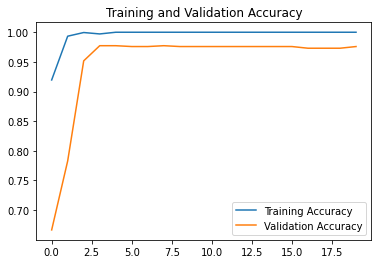

<Figure size 432x288 with 0 Axes>

/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


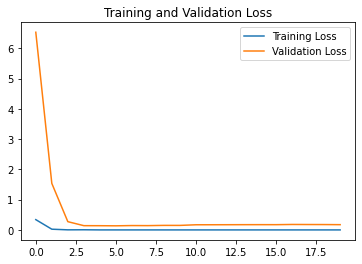

<Figure size 432x288 with 0 Axes>

In [17]:
ResNet101v2_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(150,150,3), classes=3)

#for layers in ResNet5v2_model.layers:
#    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet101v2_x = Flatten()(ResNet101v2_model.output)
resnet101v2_x = Dense(256,activation='relu')(resnet101v2_x)
resnet101v2_x = Dense(3,activation='softmax')(resnet101v2_x)
resnet101v2_x_final_model = Model(inputs=ResNet101v2_model.input, outputs=resnet101v2_x)
resnet101v2_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = resnet_epoch
resnet_filepath = 'resnet101v2'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]

resnet101v2_x_final_model.summary()
since = time.time()
resnet101v2_history = resnet101v2_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=callbacklist,verbose=1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))

do_history_stuff(resnet101v2_history, 'resnet101v2_model')

In [18]:
resnet101v2_x_final_model.evaluate(test_generator)
resnet101v2_best_model = resnet101v2_x_final_model

  ...
    to  
  ['...']
72/72 [==============================] - 16s 222ms/step - loss: 5.3262 - acc: 0.4590


## EfficientNetB7

last layer output shape:  (None, 2560)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 64)   1728        input_5[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 64)   256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 64)   0           stem_bn[0][0]                    
_____________________________________________________

block4i_expand_activation (Acti (None, 10, 10, 960)  0           block4i_expand_bn[0][0]          
__________________________________________________________________________________________________
block4i_dwconv (DepthwiseConv2D (None, 10, 10, 960)  8640        block4i_expand_activation[0][0]  
__________________________________________________________________________________________________
block4i_bn (BatchNormalization) (None, 10, 10, 960)  3840        block4i_dwconv[0][0]             
__________________________________________________________________________________________________
block4i_activation (Activation) (None, 10, 10, 960)  0           block4i_bn[0][0]                 
__________________________________________________________________________________________________
block4i_se_squeeze (GlobalAvera (None, 960)          0           block4i_activation[0][0]         
__________________________________________________________________________________________________
block4i_se

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 66 steps, validate for 705 steps
Epoch 1/60
65/66 [============================>.] - ETA: 0s - loss: 0.5843 - acc: 0.7742
Epoch 00001: val_acc improved from -inf to 0.89362, saving model to effb7--saved-model-01-acc-0.89.hdf5
66/66 [==============================] - 61s 927ms/step - loss: 0.5817 - acc: 0.7748 - val_loss: 0.2695 - val_acc: 0.8936
Epoch 2/60
65/66 [============================>.] - ETA: 0s - loss: 0.3493 - acc: 0.8574
Epoch 00002: val_acc improved from 0.89362 to 0.90922, saving model to effb7--saved-model-02-acc-0.91.hdf5
66/66 [==============================] - 48s 732ms/step - loss: 0.3471 - acc: 0.8581 - val_loss: 0.2647 - val_acc: 0.9092
Epoch 3/60
65/66 [============================>.] - ETA: 0s - loss: 0.2520 - acc: 0.9110
Epoch 00003: val_acc did not improve from 0.90922

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
66/66 [==============================] - 47s 713ms/ste

/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


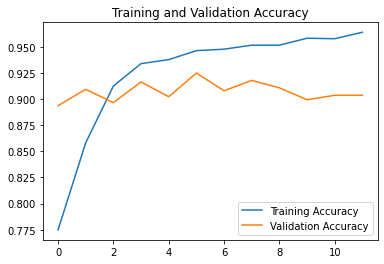

<Figure size 432x288 with 0 Axes>

/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


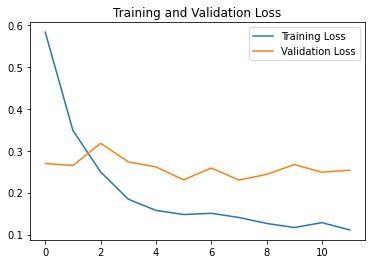

<Figure size 432x288 with 0 Axes>

In [19]:
effb7_model = EfficientNetB7(pooling='avg', 
                    weights='imagenet', 
                    include_top=False, 
                    input_shape=(150,150,3))
for layers in effb7_model.layers:
            layers.trainable=False

last_layer = effb7_model.get_layer('avg_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
effb7_x = Flatten()(last_output)
effb7_x = Dense(1024, activation = 'relu')(effb7_x)
effb7_x = Dropout(0.2)(effb7_x)
effb7_x = Dense(3, activation = 'softmax')(effb7_x)
effb7_final_model = Model(effb7_model.input, effb7_x)
effb7_final_model.compile(loss = 'categorical_crossentropy',
                          optimizer= 'adam', 
                          metrics=['acc'])

# EFFB7
number_of_epochs = effnet_epoch
effb7_final_model.summary()

effb7_filepath = 'effb7-'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(effb7_filepath, monitor='val_acc', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=1, verbose=1, mode='min', epsilon=0.0001, min_lr=0)
es = EarlyStopping(monitor='val_loss', patience=4, verbose=0, mode='min', restore_best_weights=True)
callbacks_list = [checkpoint, reduce_lr, es]

since = time.time()
effb7_history = effb7_final_model.fit(train_generator,
                                      epochs = number_of_epochs,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(effb7_history, 'effb7_model')

In [20]:
effb7_final_model.evaluate(test_generator)
effb7_best_model = effb7_final_model

  ...
    to  
  ['...']
72/72 [==============================] - 17s 238ms/step - loss: 3.0979 - acc: 0.4808


## EfficientNetL2

last layer output shape:  (None, 5504)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 75, 75, 136)  3672        input_6[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 75, 75, 136)  544         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 75, 75, 136)  0           stem_bn[0][0]                    
_____________________________________________________

block2c_expand_bn (BatchNormali (None, 38, 38, 624)  2496        block2c_expand_conv[0][0]        
__________________________________________________________________________________________________
block2c_expand_activation (Acti (None, 38, 38, 624)  0           block2c_expand_bn[0][0]          
__________________________________________________________________________________________________
block2c_dwconv (DepthwiseConv2D (None, 38, 38, 624)  5616        block2c_expand_activation[0][0]  
__________________________________________________________________________________________________
block2c_bn (BatchNormalization) (None, 38, 38, 624)  2496        block2c_dwconv[0][0]             
__________________________________________________________________________________________________
block2c_activation (Activation) (None, 38, 38, 624)  0           block2c_bn[0][0]                 
__________________________________________________________________________________________________
block2c_se

block6o_dwconv (DepthwiseConv2D (None, 5, 5, 4944)   123600      block6o_expand_activation[0][0]  
__________________________________________________________________________________________________
block6o_bn (BatchNormalization) (None, 5, 5, 4944)   19776       block6o_dwconv[0][0]             
__________________________________________________________________________________________________
block6o_activation (Activation) (None, 5, 5, 4944)   0           block6o_bn[0][0]                 
__________________________________________________________________________________________________
block6o_se_squeeze (GlobalAvera (None, 4944)         0           block6o_activation[0][0]         
__________________________________________________________________________________________________
block6o_se_reshape (Reshape)    (None, 1, 1, 4944)   0           block6o_se_squeeze[0][0]         
__________________________________________________________________________________________________
block6o_se

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 66 steps, validate for 705 steps
Epoch 1/60
65/66 [============================>.] - ETA: 0s - loss: 8.0039 - acc: 0.3337
Epoch 00001: val_acc improved from -inf to 0.33333, saving model to effl2--saved-model-01-acc-0.33.hdf5
66/66 [==============================] - 157s 2s/step - loss: 7.8943 - acc: 0.3329 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 2/60
65/66 [============================>.] - ETA: 0s - loss: 1.1004 - acc: 0.3201
Epoch 00002: val_acc did not improve from 0.33333

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
66/66 [==============================] - 122s 2s/step - loss: 1.1004 - acc: 0.3186 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 3/60
65/66 [============================>.] - ETA: 0s - loss: 1.0986 - acc: 0.3211
Epoch 00003: val_acc did not improve from 0.33333

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
66/66 [===========================

/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


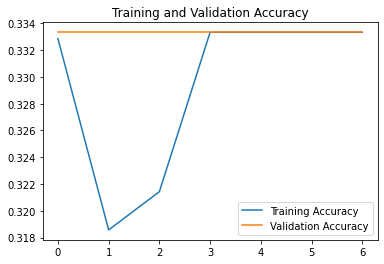

<Figure size 432x288 with 0 Axes>

/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ai2/anaconda3/envs/miscnn/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


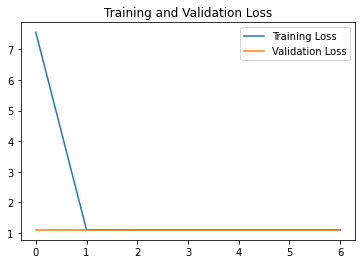

<Figure size 432x288 with 0 Axes>

In [21]:
path_weight = '/mnt/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/model/efficientnet/noisy-student/notop/efficientnet-l2_noisy-student_notop.h5'
effl2_model = EfficientNetL2(pooling='avg', 
                             weights=path_weight, 
                             include_top=False, 
                             input_shape=(150,150,3),
                             drop_connect_rate=0)
for layers in effl2_model.layers:
            layers.trainable=False

last_layer = effl2_model.get_layer('avg_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
effl2_x = Flatten()(last_output)
effl2_x = Dense(1024, activation = 'relu')(effl2_x)
effl2_x = Dropout(0.2)(effl2_x)
effl2_x = Dense(3, activation = 'softmax')(effl2_x)
effl2_final_model = Model(effl2_model.input, effl2_x)
effl2_final_model.compile(loss = 'categorical_crossentropy',
                          optimizer= 'adam', 
                          metrics=['acc'])

# EFFL2
number_of_epochs = effnet_epoch
effl2_final_model.summary()

effl2_filepath = 'effl2-'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(effl2_filepath, monitor='val_acc', verbose=1, save_best_only=True)
callbacks_list = [checkpoint, reduce_lr, es]

since = time.time()
effl2_history = effl2_final_model.fit(train_generator,
                                      epochs = number_of_epochs,
                                      validation_data = validation_generator,
                                      callbacks = callbacks_list,
                                      verbose = 1)
elapsed_time = time.time() - since
print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
do_history_stuff(effl2_history, 'effl2_model')

In [22]:
effl2_final_model.evaluate(test_generator)
effl2_best_model = effl2_final_model

  ...
    to  
  ['...']
72/72 [==============================] - 37s 511ms/step - loss: 1.0986 - acc: 0.3332


## Combining Similar Model 

In [46]:
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
resnet101_pred = []
resnet101v2_pred = []
combined1_pred = []
combined2_pred = []
combined3_pred = []
combined4_pred = []
combined5_pred = []
combined6_pred = []
combined7_pred = []
combined8_pred = []
combined9_pred = []
combined10_pred = []
combined11_pred = []
combined12_pred = []
combined13_pred = []
combined14_pred = []
combined15_pred = []
for folder in os.listdir(val_folders):
    
    val_image_ids = os.listdir(os.path.join(val_folders,folder))
    
    for image_id in val_image_ids[:int(len(val_image_ids))]:
        
        path = os.path.join(val_folders,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))
        img_normalized = img/255
        
        #vgg16
        vgg16_image_prediction = np.argmax(vgg16_best_model.predict(np.array([img_normalized])))
        
        #resnet101
        resnet101_image_prediction = np.argmax(resnet101_best_model.predict(np.array([img_normalized])))
        resnet101_pred.append(resnet101_image_prediction)
        
        #effnetb7
        effnetb7_image_prediction = np.argmax(effb7_best_model.predict(np.array([img_normalized])))
        
        #vgg19
        vgg19_image_prediction = np.argmax(vgg19_best_model.predict(np.array([img_normalized])))
        
        #resnet50v2
        resnet101v2_image_prediction = np.argmax(resnet101v2_best_model.predict(np.array([img_normalized])))
        resnet101v2_pred.append(resnet101v2_image_prediction)
        
        #effnetl2
        effnetl2_image_prediction = np.argmax(effl2_best_model.predict(np.array([img_normalized])))
        
        image_prediction = mode([resnet101v2_image_prediction, vgg16_image_prediction])                                  
        combined1_pred.append(image_prediction)
        
        image_prediction = mode([resnet101v2_image_prediction, vgg19_image_prediction])                                  
        combined2_pred.append(image_prediction)
        
        image_prediction = mode([resnet101v2_image_prediction, resnet101_image_prediction])                                  
        combined3_pred.append(image_prediction)
        
        image_prediction = mode([resnet101v2_image_prediction, effnetb7_image_prediction])                                  
        combined4_pred.append(image_prediction)
        
        image_prediction = mode([resnet101v2_image_prediction, effnetl2_image_prediction])                                  
        combined5_pred.append(image_prediction)
        
        image_prediction = mode([resnet101v2_image_prediction, vgg16_image_prediction, vgg19_image_prediction])                                  
        combined6_pred.append(image_prediction)
        
        image_prediction = mode([resnet101v2_image_prediction, vgg16_image_prediction, resnet101_image_prediction])                                  
        combined7_pred.append(image_prediction)
        
        image_prediction = mode([resnet101v2_image_prediction, vgg16_image_prediction, effnetb7_image_prediction])                                  
        combined8_pred.append(image_prediction)
        
        image_prediction = mode([resnet101v2_image_prediction, vgg16_image_prediction, effnetl2_image_prediction])                                  
        combined9_pred.append(image_prediction)
        
        image_prediction = mode([resnet101v2_image_prediction, vgg16_image_prediction, vgg19_image_prediction, resnet101_image_prediction])                                  
        combined10_pred.append(image_prediction)
        
        image_prediction = mode([resnet101v2_image_prediction, vgg16_image_prediction, resnet101_image_prediction, effnetb7_image_prediction])                                  
        combined11_pred.append(image_prediction)
        
        image_prediction = mode([resnet101v2_image_prediction, vgg16_image_prediction, vgg19_image_prediction, effnetl2_image_prediction])                                  
        combined12_pred.append(image_prediction)
        
        image_prediction = mode([resnet101v2_image_prediction, vgg16_image_prediction, vgg19_image_prediction, resnet101_image_prediction, effnetb7_image_prediction])                                  
        combined13_pred.append(image_prediction)
        
        image_prediction = mode([resnet101v2_image_prediction, vgg16_image_prediction, vgg19_image_prediction, resnet101_image_prediction, effnetl2_image_prediction])                                  
        combined14_pred.append(image_prediction)
        
        image_prediction = mode([resnet101v2_image_prediction, vgg16_image_prediction, vgg19_image_prediction, resnet101_image_prediction, effnetb7_image_prediction, effnetl2_image_prediction])                                  
        combined15_pred.append(image_prediction)

## Define Classification

In [47]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

## Result of Classification

Model Accuracy 0.9687943262411347
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       0.99      0.91      0.95       235
   sclerosed       0.92      0.99      0.95       235

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705



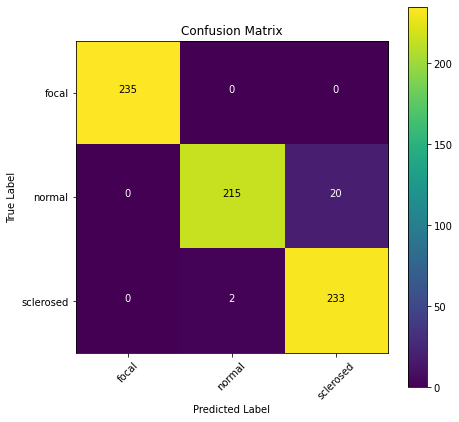

In [48]:
clf_report(true_value, resnet101_pred)

Model Accuracy 0.9716312056737588
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       0.99      0.92      0.96       235
   sclerosed       0.93      0.99      0.96       235

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705



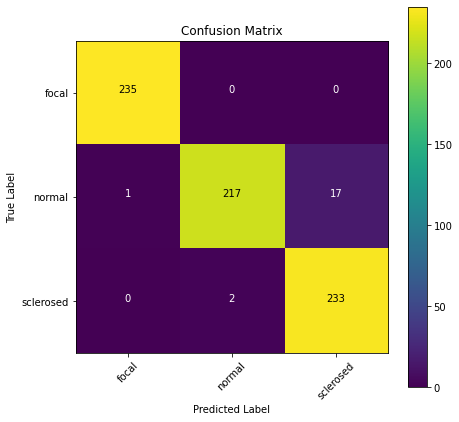

In [49]:
clf_report(true_value, resnet101v2_pred)

Model Accuracy 0.9716312056737588
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       0.99      0.92      0.96       235
   sclerosed       0.93      0.99      0.96       235

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705



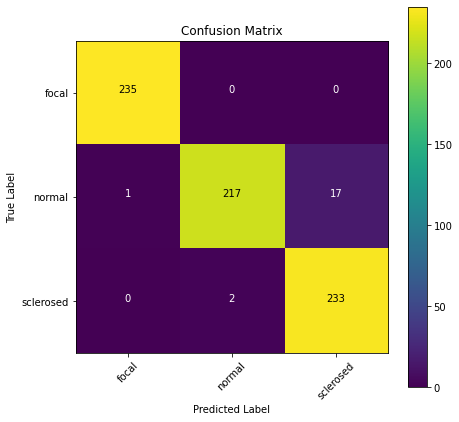

In [50]:
#combined1
combined1_pred = [ c[0] for c in combined1_pred]
clf_report(true_value, combined1_pred)

Model Accuracy 0.9716312056737588
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       0.99      0.92      0.96       235
   sclerosed       0.93      0.99      0.96       235

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705



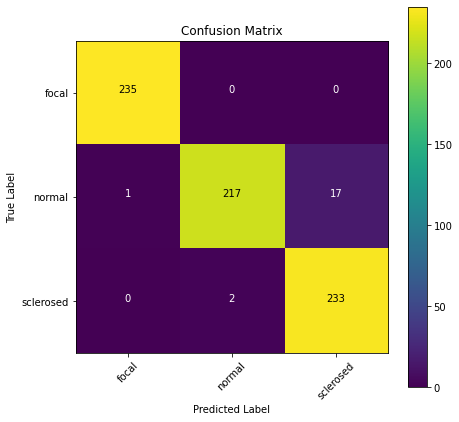

In [51]:
#combined2
combined2_pred = [ c[0] for c in combined2_pred]
clf_report(true_value, combined2_pred)

Model Accuracy 0.9716312056737588
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       0.99      0.92      0.96       235
   sclerosed       0.93      0.99      0.96       235

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705



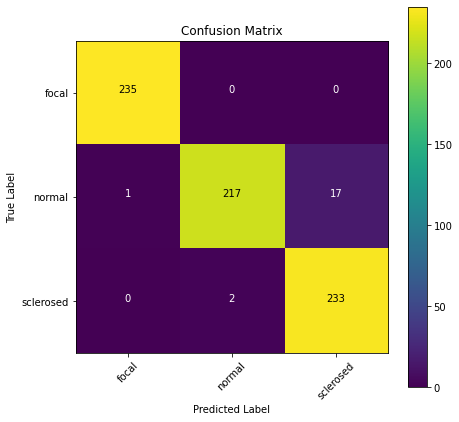

In [52]:
#combined3
combined3_pred = [ c[0] for c in combined3_pred]
clf_report(true_value, combined3_pred)

Model Accuracy 0.9716312056737588
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       0.99      0.92      0.96       235
   sclerosed       0.93      0.99      0.96       235

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705



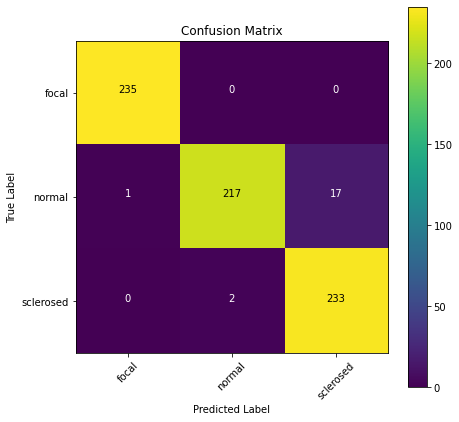

In [53]:
#combined4
combined4_pred = [ c[0] for c in combined4_pred]
clf_report(true_value, combined4_pred)

Model Accuracy 0.9716312056737588
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       0.99      0.92      0.96       235
   sclerosed       0.93      0.99      0.96       235

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705



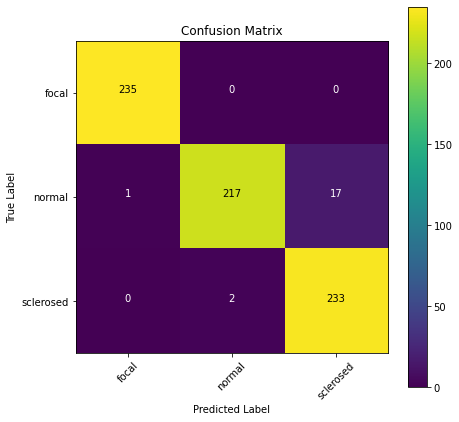

In [54]:
#combined5
combined5_pred = [ c[0] for c in combined5_pred]
clf_report(true_value, combined5_pred)

Model Accuracy 0.9446808510638298
              precision    recall  f1-score   support

       focal       0.95      1.00      0.97       235
      normal       0.99      0.84      0.91       235
   sclerosed       0.90      1.00      0.95       235

    accuracy                           0.94       705
   macro avg       0.95      0.94      0.94       705
weighted avg       0.95      0.94      0.94       705



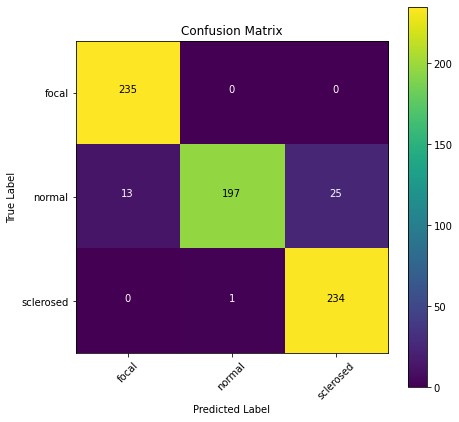

In [55]:
#combined6
combined6_pred = [ c[0] for c in combined6_pred]
clf_report(true_value, combined6_pred)

Model Accuracy 0.9687943262411347
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       0.99      0.91      0.95       235
   sclerosed       0.92      0.99      0.95       235

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705



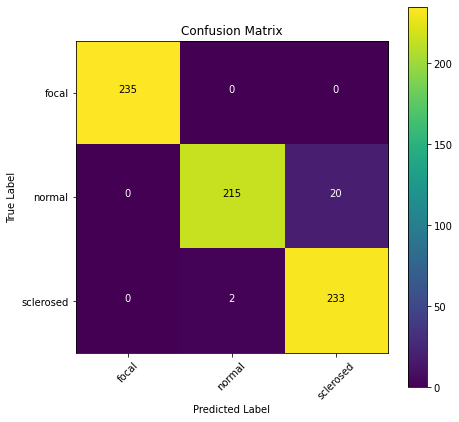

In [56]:
#combined7
combined7_pred = [ c[0] for c in combined7_pred]
clf_report(true_value, combined7_pred)

Model Accuracy 0.9702127659574468
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       1.00      0.91      0.95       235
   sclerosed       0.92      1.00      0.96       235

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705



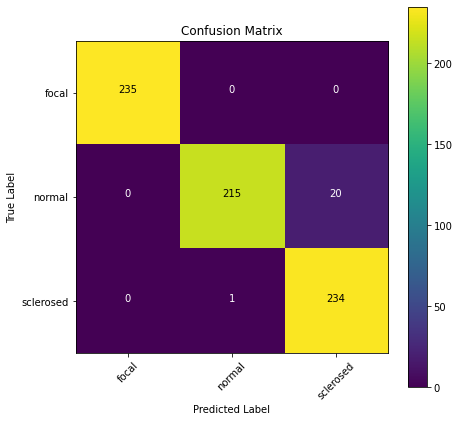

In [57]:
#combined8
combined8_pred = [ c[0] for c in combined8_pred]
clf_report(true_value, combined8_pred)

Model Accuracy 0.9560283687943263
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       0.94      0.93      0.93       235
   sclerosed       0.93      0.94      0.93       235

    accuracy                           0.96       705
   macro avg       0.96      0.96      0.96       705
weighted avg       0.96      0.96      0.96       705



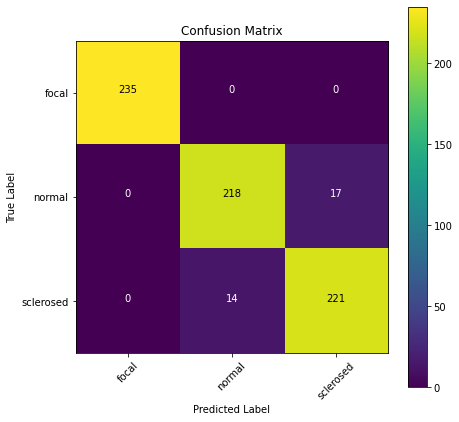

In [58]:
#combined9
combined9_pred = [ c[0] for c in combined9_pred]
clf_report(true_value, combined9_pred)

Model Accuracy 0.9659574468085106
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       0.99      0.91      0.95       235
   sclerosed       0.92      0.99      0.95       235

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705



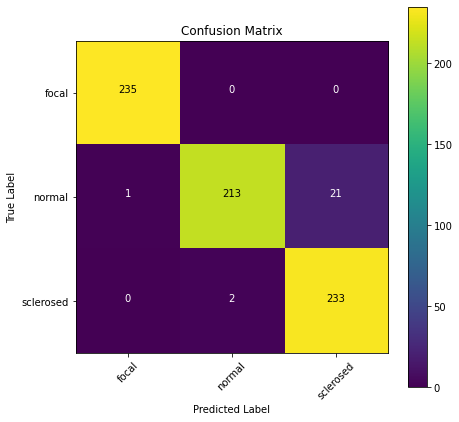

In [59]:
#combined10
combined10_pred = [ c[0] for c in combined10_pred]
clf_report(true_value, combined10_pred)

Model Accuracy 0.9730496453900709
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       0.99      0.93      0.96       235
   sclerosed       0.93      0.99      0.96       235

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705



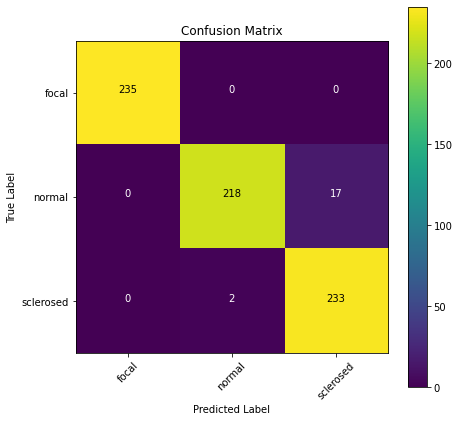

In [60]:
#combined11
combined11_pred = [ c[0] for c in combined11_pred]
clf_report(true_value, combined11_pred)

Model Accuracy 0.9730496453900709
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       0.99      0.93      0.96       235
   sclerosed       0.93      0.99      0.96       235

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705



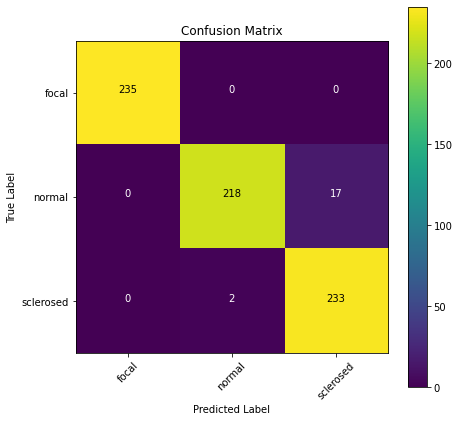

In [61]:
#combined12
combined12_pred = [ c[0] for c in combined12_pred]
clf_report(true_value, combined12_pred)

Model Accuracy 0.9673758865248226
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       1.00      0.90      0.95       235
   sclerosed       0.91      1.00      0.95       235

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705



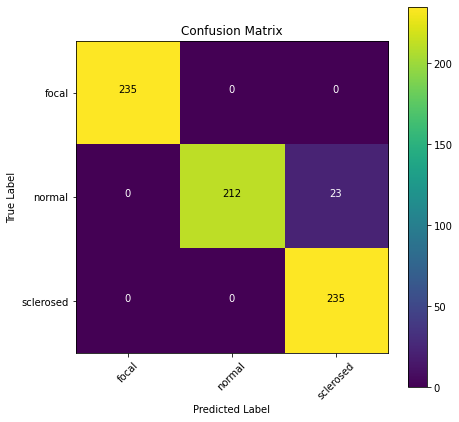

In [62]:
#combined13
combined13_pred = [ c[0] for c in combined13_pred]
clf_report(true_value, combined13_pred)

Model Accuracy 0.9687943262411347
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       0.99      0.91      0.95       235
   sclerosed       0.92      0.99      0.95       235

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705



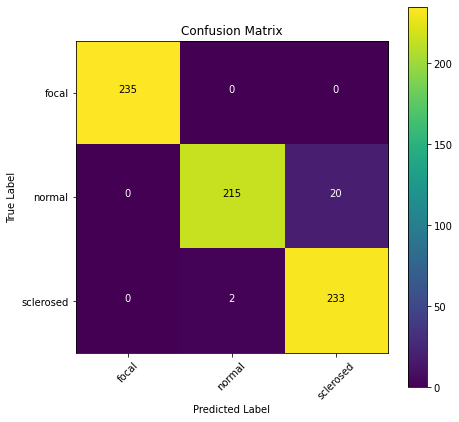

In [63]:
#combined14
combined14_pred = [ c[0] for c in combined14_pred]
clf_report(true_value, combined14_pred)

Model Accuracy 0.9730496453900709
              precision    recall  f1-score   support

       focal       1.00      1.00      1.00       235
      normal       0.99      0.93      0.96       235
   sclerosed       0.93      0.99      0.96       235

    accuracy                           0.97       705
   macro avg       0.97      0.97      0.97       705
weighted avg       0.97      0.97      0.97       705



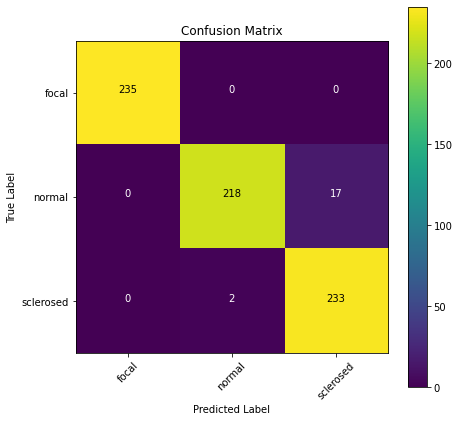

In [64]:
#combined15
combined15_pred = [ c[0] for c in combined15_pred]
clf_report(true_value, combined15_pred)